In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.integrate import odeint
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import compute_VAR_p_over_lamb, construct_dictionary, perform_stability_analysis, get_stability_results, predict_EDMD, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# EDMD Analysis

In [6]:
def vdp(x, t, mu):
    dx = np.zeros(2)
    dx[0] = x[1]
    dx[1] = mu*(1 - x[0]**2)*x[1] - x[0]
    return dx

def RK4(func, t0, y0, t_bound, dt=0.1, verbose=False):
    y_vals = np.zeros((int(t_bound/dt), len(y0)))
    t_vals = np.arange(y_vals.shape[0])*dt
    t = t0
    y = y0
    y_vals[0] = y
    for i, t in tqdm(enumerate(t_vals), disable=not verbose, total=len(t_vals)):
        k1 = func(t, y)
        k2 = func(t + dt/2, y + dt*k1/2)
        k3 = func(t + dt/2, y + dt*k2/2)
        k4 = func(t + dt, y + dt*k3)
        y += (1/6)*(k1 + 2*k2 + 2*k3 + k4)*dt
        y_vals[i] = y
    
    return y_vals, t_vals

In [52]:
indices = np.arange(2)
signals = {}
delayed_mis = {}
taus = {}
signal_analysis = {}

total_time = 3000 # s
dt = 0.001 # s
T = int(total_time/dt)
# mu_vals = [0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4]
mu_vals = [0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1, 1.25, 2, 3, 4, 5]
# mu_vals = [5]
for mu in tqdm(mu_vals):
    x0 = np.random.randn()*2
    y0 = np.random.randn()*2

#     x0, y0 = (2.07054206, -0.84573278)
    
    # ------------
    # SCIPY
    # -----------
    
    t = np.arange(0.0, total_time, dt)
    data = odeint(lambda x, t: vdp(x, t, mu=mu), [x0, y0], t)

#     # ------------
#     # RUNGE KUTTA
#     # -----------
#     dynamic_noise_sd = 1
#     verbose = True
#     y, t = RK4(lambda t, v: np.array([v[1] + np.random.randn()*dynamic_noise_sd, mu*(1 - v[0]**2)*v[1] - v[0] + np.random.randn()*dynamic_noise_sd]), 0, (np.random.randn()*2, np.random.randn()*2), t_bound=total_time, dt=dt, verbose=True)
#     data = y
    
    # ------------
    # DELAYED MI
    # -----------
    num_lags = 200

    delayed_mi = np.zeros(num_lags + 1)
    for t in tqdm(range(num_lags + 1)):
        for i in range(data.shape[1]):
            delayed_mi[t] += delay.mi(data[:T-t, i], data[t:, i], bins=64)
        delayed_mi[t] /= data.shape[1]
    
    delayed_mis[f"mu = {mu}"] = delayed_mi
    local_min_inds = scipy.signal.argrelextrema(delayed_mi, np.less)[0]
    if len(local_min_inds) == 0:
        tau = delayed_mi.argmin()
    else:
        tau = local_min_inds[0]
    taus[f"mu = {mu}"] = tau
    print(f"mu = {mu}, tau = {tau}")
    signals[f"mu = {mu}"] = data[np.arange(0, data.shape[0], tau)]
#     signals[f"mu = {mu}"] = data
        
signal_analysis = {}

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [73]:
# pd.to_pickle({'signals': signals, 'taus': taus, 'delayed_mis': delayed_mis, 'dt': dt}, "vdp_data.pkl")
ret = pd.read_pickle("vdp_data.pkl")
signals = ret['signals']
taus = ret['taus']
delayed_mis = ret['delayed_mis']
dt = ret['dt']

In [74]:
for key, signal in signals.items():
    signals[key] = np.hstack([signal, np.reshape(np.multiply(signal[:, 0]**2, signal[:, 1]), (-1, 1))])
indices = np.arange(3)

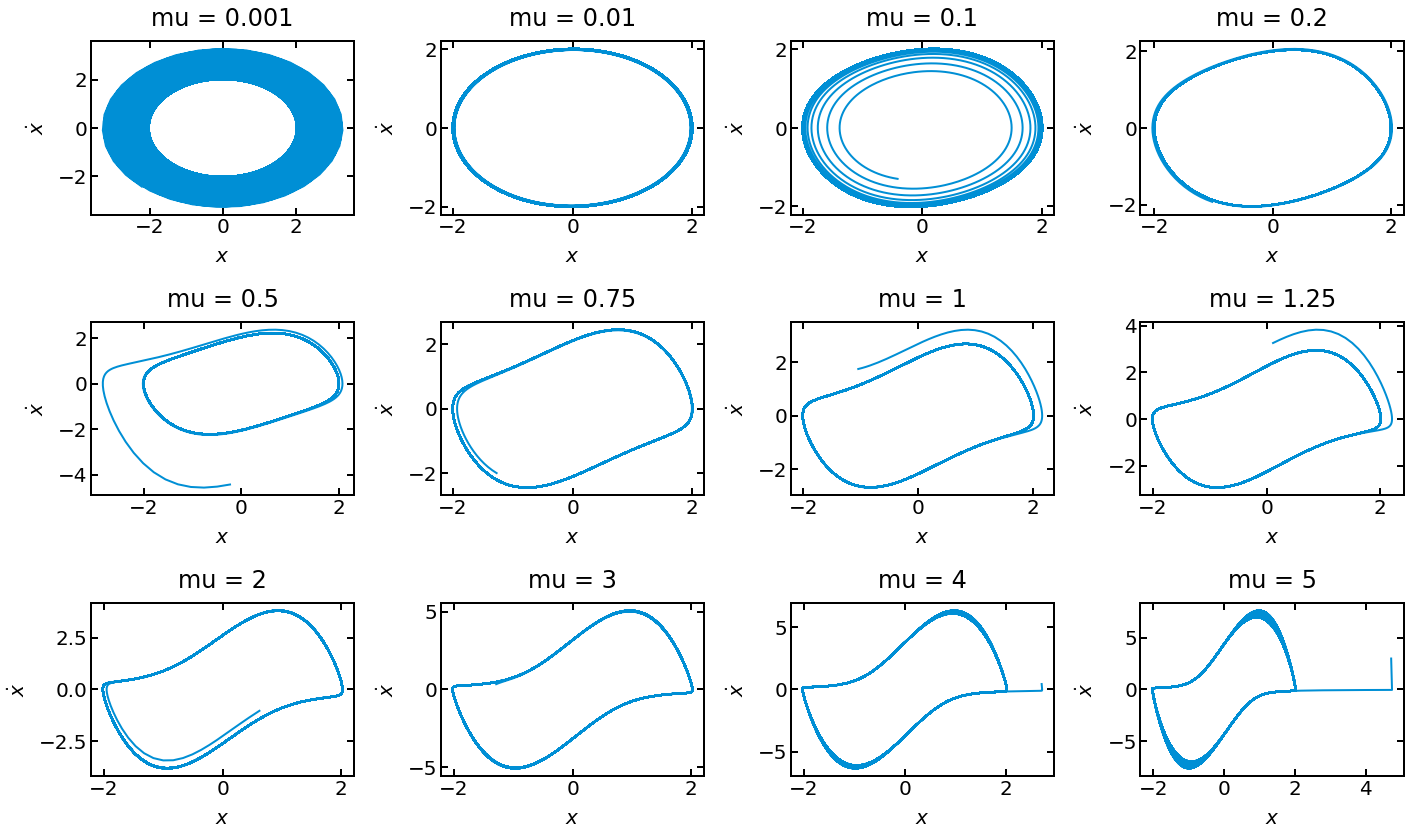

In [75]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(20, 12))

for i, (key, signal) in enumerate(signals.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    ax.plot(signal[:, 0], signal[:, 1])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    ax.set_title(f"{key}")
plt.tight_layout()
plt.show()

In [173]:
signal_analysis = {}

In [174]:
# ------------------
# EDMD
# ------------------
# max_lag = 3
# method = 'EDMD'
# # lamb = 0.01
# lamb_vals = [0, 1e-12, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.5, 2, 3, 5, 10, 25, 50, 100, 250, 500]
# trim_CIs=True
# use_lamb_for_full_results=True
# dictionary_method = 'hermite'
# max_order = 0
# grouped_by = 2
# include_signal=True
# normalize=False


# projection_dim = -1
# N = projection_dim if projection_dim > 0 else len(indices)
# dim_init = N
# # PCA_dim = -1
# # dim_init = PCA_dim if PCA_dim > 1 else len(indices)
# N_groups = np.int0(np.ceil(dim_init*np.arange(1, max_lag + 1)/grouped_by))
# D = ((max_order + 1)**grouped_by - 1)*N_groups + 1
# if include_signal:
#     D += len(indices)*np.arange(1, max_lag + 1)
# print(f"dictionary dimension is {D}")

# kwargs = dict(
#     method=method,
# #     lamb=lamb,
#     lamb=lamb_vals,
#     trim_CIs=trim_CIs,
#     use_lamb_for_full_results=use_lamb_for_full_results,
#     dictionary_method=dictionary_method,
#     max_order=max_order,
#     grouped_by=grouped_by,
#     include_signal=include_signal,
#     normalize=normalize
# )

# # ------------------
# # VAR(p)
# # ------------------

method = 'VAR(p)'
max_lag = 25
projection_dim = -1
N = 2
D = 2*np.arange(1, max_lag + 1) + 1
print(f"dictionary dimension is {D}")

use_lamb_for_full_results=True
trim_CIs = True
# lamb = 1.5
# lamb_vals = [0, 0.001, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.5, 2, 3, 5, 10, 15, 20, 25, 50, 75, 100]
# lamb_vals = [0, 1e-12, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.5, 2, 3, 5, 10, 25, 50, 100, 250, 500]
lamb_vals = 1

kwargs = dict(
    method=method,
    lamb=lamb_vals,
    use_lamb_for_full_results=use_lamb_for_full_results,
    trim_CIs=trim_CIs,
)

dictionary dimension is [ 3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49
 51]


In [175]:
# min_window = max([1.5*N*max_lag*dt, 500*dt_eff, D[-1]*dt_eff]) # s
# min_window = max([1.5*N*max_lag*dt, 500*dt]) # s
min_window = np.max(np.hstack([1.5*N*max_lag*dt*np.array(list(taus.values())), 500*dt*np.array(list(taus.values())), D[-1]*dt*np.array(list(taus.values()))]))
print(f"Minimum window is {min_window} seconds")
max_window = np.min(10000*dt*np.array(list(taus.values())))
print(f"Maximum window is {max_window} seconds")

Minimum window is 100.0 seconds
Maximum window is 260.0 seconds


In [176]:
# windows = np.arange(100, 275, 25)
windows = [100]

T_pred = 500
num_window_samples = 5

kwargs['T_pred'] = T_pred
kwargs['num_window_samples'] = num_window_samples
kwargs['verbose'] = True

In [177]:
if projection_dim > 0:
    projection_mat = np.random.randn(len(indices), projection_dim)
else:
    projection_mat = np.eye(len(indices))

In [178]:
for key, signal in signals.items():
    if key not in signal_analysis.keys():
        print(f"now computing: {key}")
        kwargs['dt'] = dt*taus[key]
        data = signal[:, indices] @ projection_mat
#         VAR_results, grid_search_df, test_mse_mat, window, p = perform_stability_analysis(data, windows, max_lag, method=method, T_pred=T_pred, num_window_samples=num_window_samples, dt=dt*subsample_step, lamb=lamb, use_lamb_for_full_results=use_lamb_for_full_results, dictionary_method=dictionary_method, max_order=max_order, grouped_by=grouped_by, include_signal=include_signal, normalize=normalize, verbose=True)
        VAR_results, grid_search_df, test_mse_mat, window, p, lamb = perform_stability_analysis(data, windows, max_lag, **kwargs)
        signal_analysis[key] = dict(
            VAR_results=VAR_results,
            grid_search_df=grid_search_df,
            test_mse_mat=test_mse_mat,
            window=window,
            p=p,
            lamb=lamb
        )

now computing: mu = 0.001


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 0.01


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 0.1


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 0.2


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 0.5


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 0.75


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 1


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 1.25


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 2


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 3


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 4


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 5


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

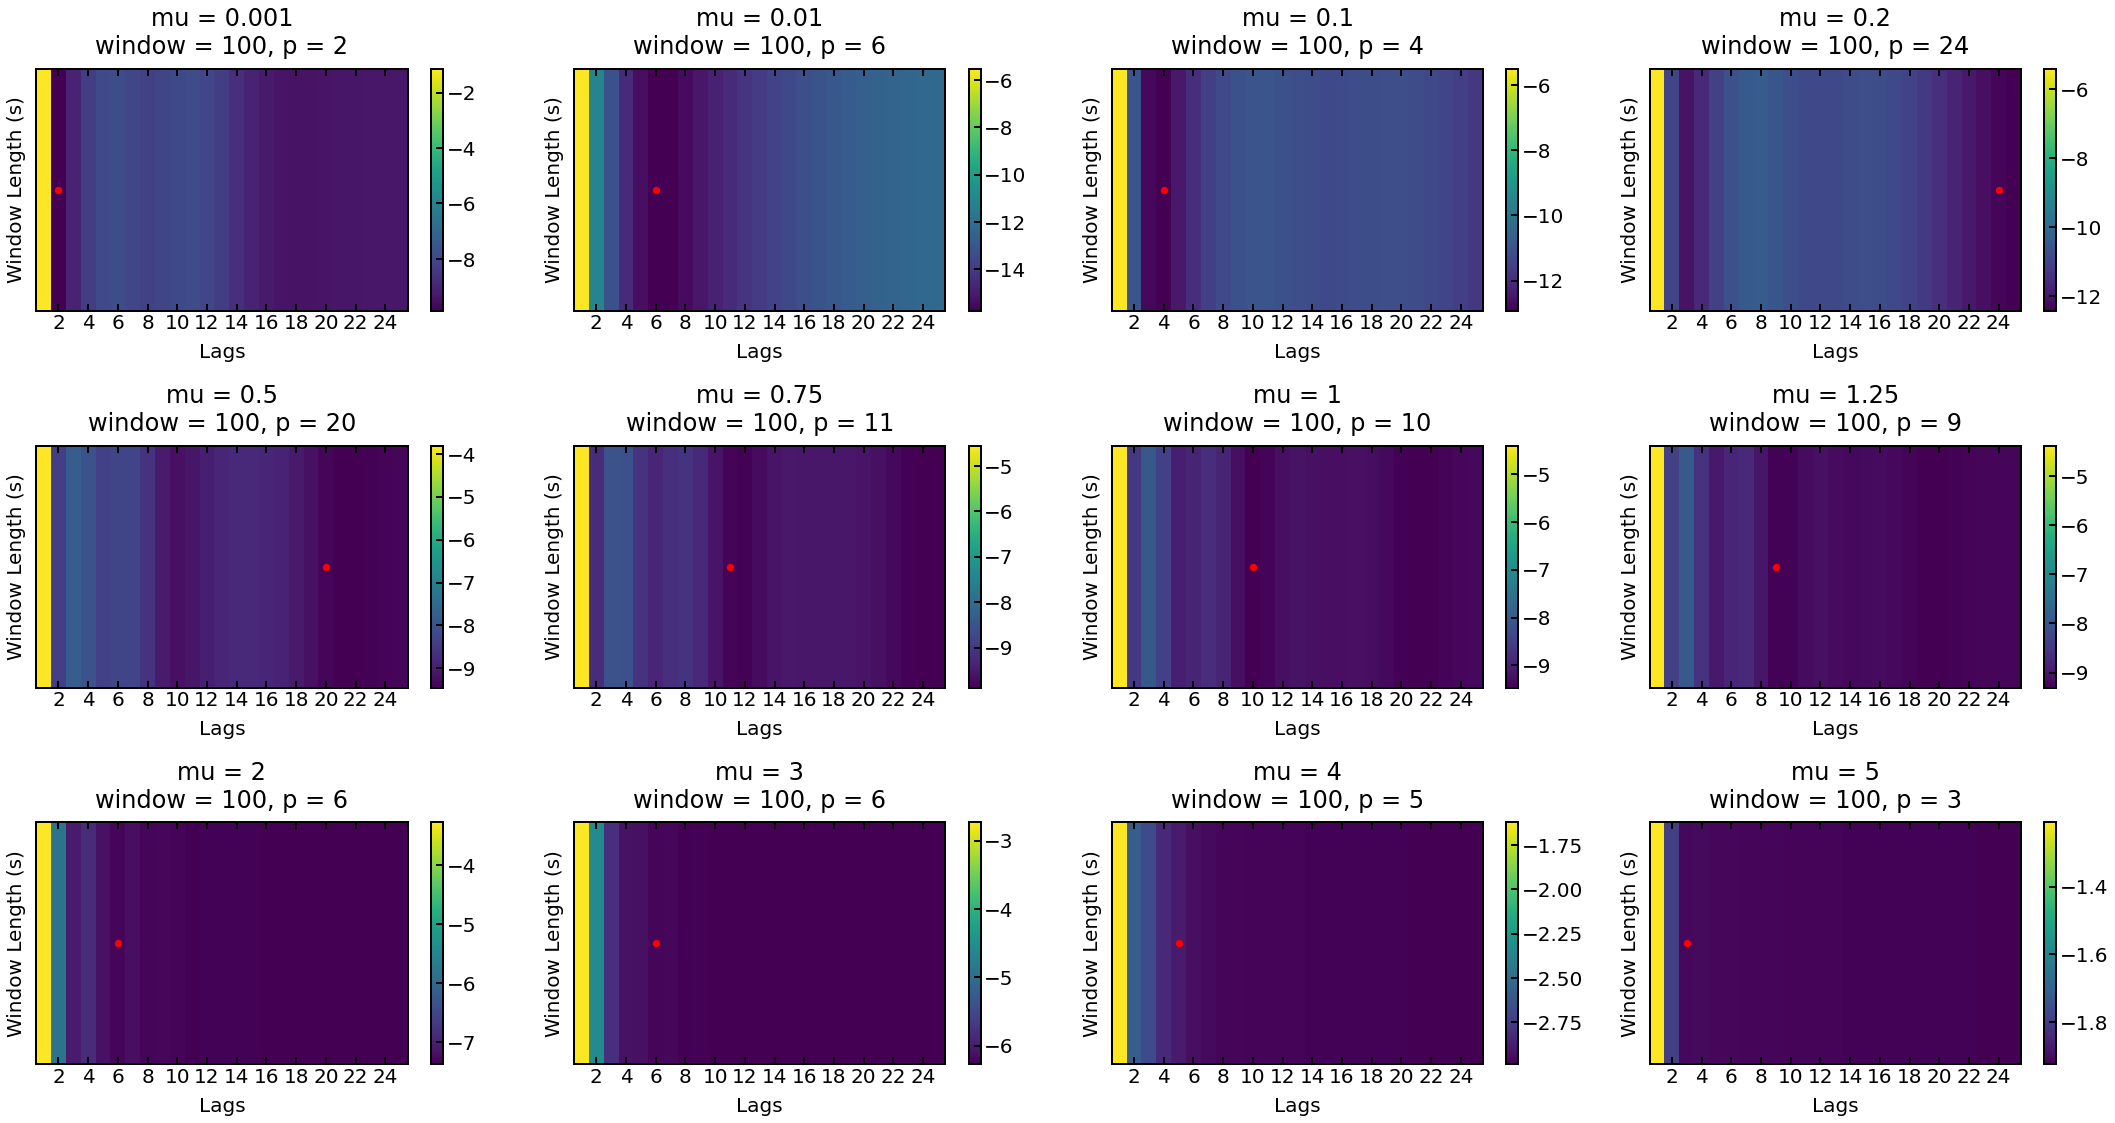

In [179]:
lags = np.arange(1, max_lag + 1)
plt.style.use('../../sci_style.py')
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(30, 16))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    log_test_mse_mat = np.log(signal_info['test_mse_mat'])
    im = ax.pcolormesh(log_test_mse_mat)
    ax.set_xticks(np.arange(1, max_lag, 2) + 0.5)
    ax.set_xticklabels([lags[i] for i in np.arange(1, max_lag, 2)])
    ax.set_yticks(np.arange(1, len(windows), 2) + 0.5)
    ax.set_yticklabels([f"{windows[i]:.2f}" for i in np.arange(1, len(windows), 2)])
    ax.set_xlabel('Lags')
    ax.set_ylabel('Window Length (s)')
    ax.set_title(f"{key}\nwindow = {signal_info['window']}, p = {signal_info['p']}")
    fig.colorbar(im, ax=ax)
    p_ind = np.where(lags == signal_info['p'])[0][0]
    w_ind = np.where(np.array(windows) == signal_info['window'])[0][0]
    ax.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()

In [180]:
# rows = 3
# cols = 4
# fig, axs = plt.subplots(rows, cols, figsize=(30, 16))

# for i, (key, signal_info) in enumerate(signal_analysis.items()):
#     if rows == 1 and cols == 1:
#         ax = axs
#     elif rows == 1 or cols == 1:
#         ax = axs[i]
#     else:
#         ax = axs[int(i/cols)][i % cols]
        
#     VAR_results = signal_info['VAR_results']
#     mode_criticalities = np.zeros((len(VAR_results), len(VAR_results.criticality_inds.iloc[0])))
#     for i, row in VAR_results.iterrows():
#         mode_criticalities[i] = np.sort(row.criticality_inds)
#     for i in range(len(VAR_results.criticality_inds.iloc[0])):
#         ax.plot((VAR_results.start_time)/60, mode_criticalities[:, i])
#     ax.set_xlabel('Time (min)')
#     ax.set_ylabel('Criticality Index')
#     ax.set_title(f"{key} criticality modes\nwindow = {signal_info['window']}, lag = {signal_info['p']}")
# plt.tight_layout()
# plt.show()

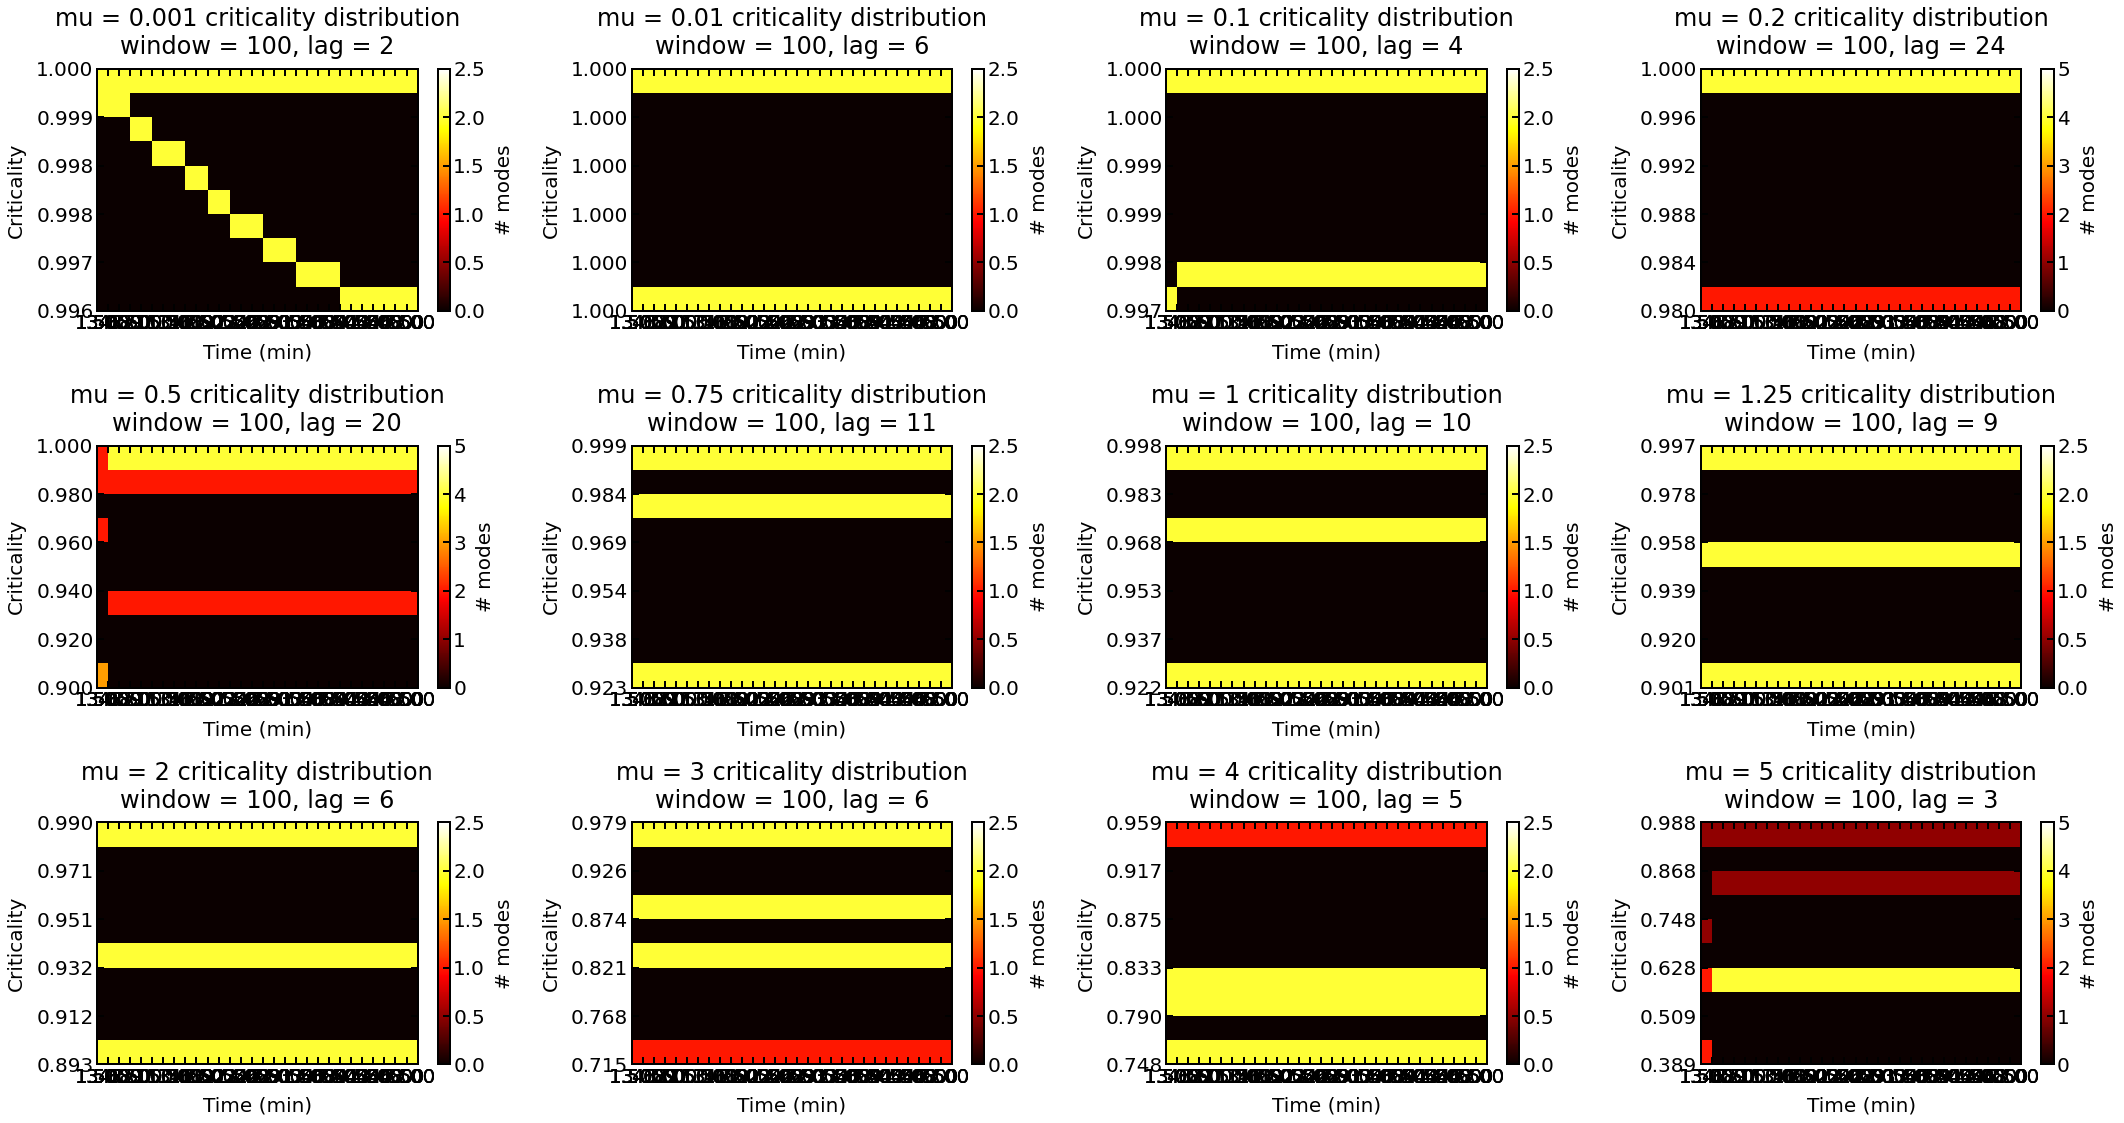

In [181]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(30, 16))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    
    VAR_results = signal_info['VAR_results']
    
    stride = VAR_results.stride.iloc[0]
    bin_nums = 10
    bin_min = np.concatenate(VAR_results.criticality_inds.to_numpy()).min()
    bin_max = np.concatenate(VAR_results.criticality_inds.to_numpy()).max()
    bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
    criticality_prob_dist = np.zeros((VAR_results.criticality_inds.shape[0], bin_nums))
    for t in range(VAR_results.criticality_inds.shape[0]):
        criticality_prob_dist[t] = np.histogram(VAR_results.criticality_inds[t], bins=bins)[0]
    start_times = np.arange(VAR_results.criticality_inds.shape[0])*stride/60
    T_max = VAR_results.criticality_inds.shape[0]*stride
    im = ax.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
    ax.set_xticks([int(i/stride) for i in np.arange(0, T_max, 30)])
    ax.set_xticklabels([f"{(int(i))/60:.2f}" for i in np.arange(0, T_max, 30)])
    ax.set_yticks(np.arange(0, bin_nums + 1, 2))
    ax.set_yticklabels([f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
    cb = fig.colorbar(im, ax=ax)
    cb.set_label(label='# modes')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Criticality")
    ax.set_title(f"{key} criticality distribution\nwindow = {signal_info['window']}, lag = {signal_info['p']}")
plt.tight_layout()
plt.show()

In [182]:
def lambda_2(mu):
    if mu < 2:
        return -mu  - (1/16)*(mu ** 3) + (263/18432)*(mu ** 5)
    elif mu >= 2 and mu <= 4:
        return (-1.2 + (mu - 2)*(-0.1))*mu
    elif mu > 4 and mu <= 5:
        return (-1.4 + (mu - 4)*(-0.05))*mu
#     elif mu == 2:
#         return -1.2*mu
#     elif mu == 3:
#         return -1.3*mu
#     elif mu == 4:
#         return -1.4*mu
#     elif mu == 5:
#         return -1.45*mu
    else:
        return None
# https://arxiv.org/pdf/2111.12198.pdf

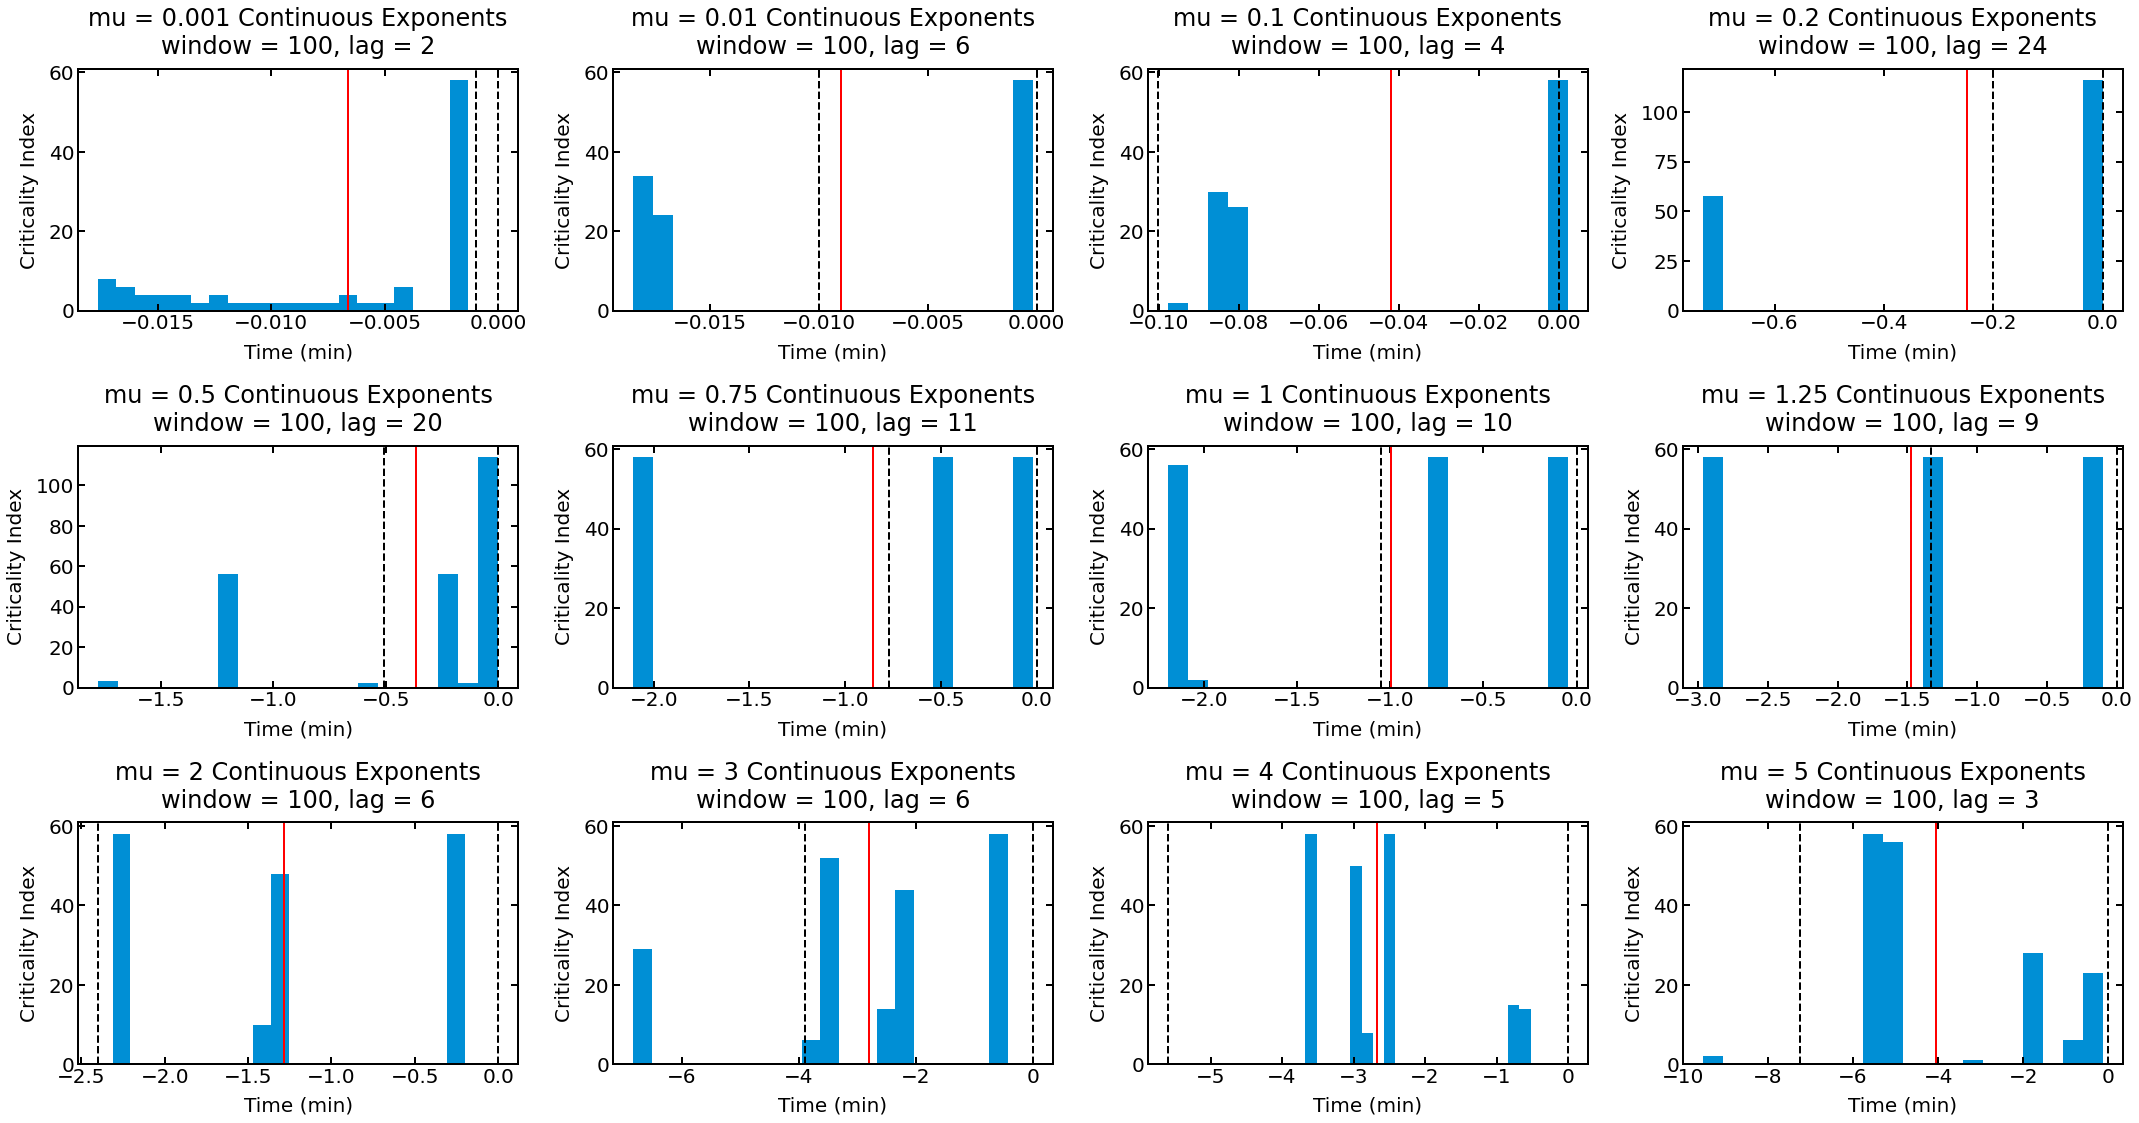

In [183]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(30, 16))

mean_vals = []
mean_top_10 = []
mean_bottom_10 = []
for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
        
    VAR_results = signal_info['VAR_results']
    criticalities = np.hstack(VAR_results.criticality_inds)
#     criticalities = criticalities[criticalities > 1e-1]
#     continuous_exps = (criticalities - 1)/(dt*taus[key])
#     continuous_exps = np.hstack(VAR_results['eigs'].apply(lambda x: np.real(np.log(x)/(dt*subsample_step))))
    continuous_exps = np.log(criticalities)/(dt*taus[key])
    ax.hist(continuous_exps, bins=20)
#     ax.hist(continuous_exps[continuous_exps > np.percentile(continuous_exps, 90)], bins=20)
    ax.axvline(lambda_2(mu_vals[i]), c='k', linestyle='--')
    ax.axvline(0, c='k', linestyle='--')
    ax.axvline(np.mean(continuous_exps), c='r')
    mean_vals.append(np.mean(continuous_exps))
    mean_bottom_10.append(continuous_exps[continuous_exps <= np.percentile(continuous_exps, 10)].mean())
    mean_top_10.append(continuous_exps[continuous_exps >= np.percentile(continuous_exps, 90)].mean())
#     mean_bottom_10.append(continuous_exps[np.logical_and(continuous_exps >= np.percentile(continuous_exps, 90), continuous_exps <= np.percentile(continuous_exps, 95))].mean())
#     mean_top_10.append(continuous_exps[continuous_exps >= np.percentile(continuous_exps, 95)].mean())
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Criticality Index')
    ax.set_title(f"{key} Continuous Exponents\nwindow = {signal_info['window']}, lag = {signal_info['p']}")
plt.tight_layout()
plt.show()

In [184]:
p_vals = [signal_analysis[f'mu = {mu}']['p'] for mu in mu_vals]

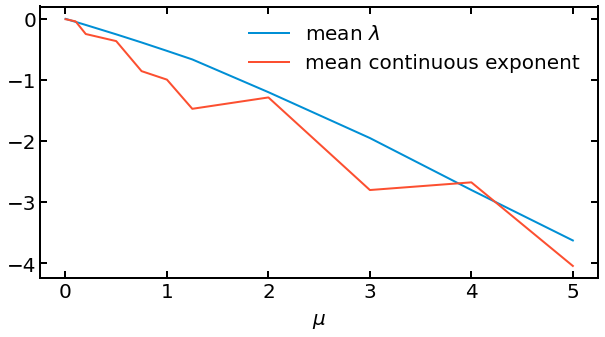

In [187]:
# plt.plot(mu_vals, np.zeros(len(mu_vals)), label=r'$\lambda_1$')
# plt.plot(mu_vals, [lambda_2(mu_vals[i]) for i in range(len(mu_vals))], label=r'$\lambda_2$')
plt.plot(mu_vals, [(0 + lambda_2(mu_vals[i]))/2 for i in range(len(mu_vals))], label=r'mean $\lambda$')
# plt.plot(mu_vals, np.array(mean_top_10), label='mean top 10%')
# plt.plot(mu_vals, np.array(mean_bottom_10), label='mean bottom 10%')
plt.plot(mu_vals, np.array(mean_vals), label='mean continuous exponent')
ax = plt.gca()
plt.xlabel(r'$\mu$')
plt.legend()
# ax2 = ax.twinx()
# ax2.plot(mu_vals, p_vals)

p = plt.show()

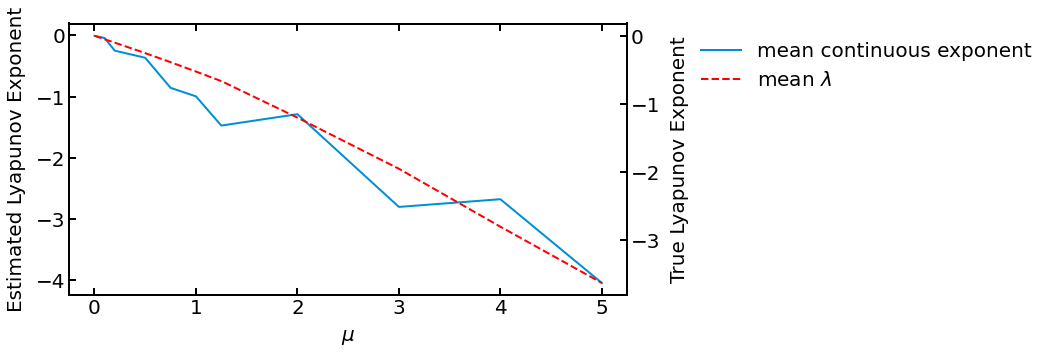

In [186]:
# plt.plot(mu_vals, np.zeros(len(mu_vals)), label=r'$\lambda_1$')
# plt.plot(mu_vals, [lambda_2(mu_vals[i]) for i in range(len(mu_vals))], label=r'$\lambda_2$')
# plt.plot(mu_vals, [(0 + lambda_2(mu_vals[i]))/2 for i in range(len(mu_vals))], label=r'mean $\lambda$')
# plt.plot(mu_vals, np.array(mean_top_10), label='mean top 10%')
# plt.plot(mu_vals, np.array(mean_bottom_10), label='mean bottom 10%')
ln1 = plt.plot(mu_vals, np.array(mean_vals), label='mean continuous exponent')
ax = plt.gca()
ax.set_ylabel('Estimated Lyapunov Exponent')
plt.xlabel(r'$\mu$')
ax2 = ax.twinx()
ln2 = ax2.plot(mu_vals, [(0 + lambda_2(mu_vals[i]))/2 for i in range(len(mu_vals))], c='red', linestyle='--', label=r'mean $\lambda$')
lns = ln1 + ln2
labs = [ln.get_label() for ln in lns]
ax2.set_ylabel('True Lyapunov Exponent')
plt.legend(lns, labs, loc='upper left', bbox_to_anchor=(1.1, 1))

p = plt.show()

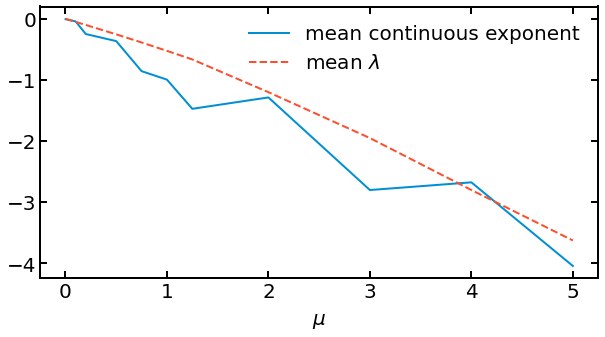

In [190]:

plt.plot(mu_vals, np.array(mean_vals), label='mean continuous exponent')
plt.plot(mu_vals, [(0 + lambda_2(mu_vals[i]))/2 for i in range(len(mu_vals))], label=r'mean $\lambda$', linestyle='--')
ax = plt.gca()
plt.xlabel(r'$\mu$')
plt.legend()
# ax2 = ax.twinx()
# ax2.plot(mu_vals, p_vals)

p = plt.show()

In [169]:
signal_analysis['mu = 0.2']['VAR_results'].S.iloc[0]

array([2.42250057e+02, 1.49851476e+02, 9.14926018e+01, 6.08154806e+01,
       9.96645474e+00, 5.17526440e-02, 3.17937741e-06, 4.08510341e-07,
       7.42539290e-08, 2.43053434e-08])

# PREDICTION

In [25]:
key = 'mu = 0.001'
window = signal_analysis[key]['window']
p = signal_analysis[key]['p']
grid_search_df = signal_analysis[key]['grid_search_df']
opt_rows = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)]

In [ ]:
opt_rows

In [219]:
i = 0
row = opt_rows.iloc[i]
sig = signals[key][row.start_ind:row.end_ind]
pred_sig = signals[key][row.end_ind - row.p:row.end_ind + 1500]

In [220]:
row.test_mse, row.pb_mse_test

(6.943038159021062e-19, 0.0015536144934114107)

In [221]:
preds, tv, pb_mse = predict_VAR_p(pred_sig, row.coefs, row.intercept, persistence_baseline=True, normalize=False)

In [222]:
pb_mse

0.0015512776733414037

In [223]:
((preds - tv)**2).mean()

1.100961993114878e-18

In [224]:
row.p

5

In [225]:
row.window

50